In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['ner.csv', 'ner_dataset.csv']


### Importing the dataset for named entity recognition model

In [2]:
df = pd.read_csv('../input/ner.csv', encoding="ISO-8859-1", error_bad_lines=False)
df = df.fillna(method="ffill")
df.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [3]:
df.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

In [4]:
data = df[['sentence_idx', 'word', 'pos', 'tag']]
data.head()

,sentence_idx,word,pos,tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O
3,1.0,have,VBP,O
4,1.0,marched,VBN,O


In [5]:
print("# sentences: ", len(data.groupby(['sentence_idx'])))

# sentences:  35177


In [6]:
words = list(set(data["word"].values))
n_words = len(words)
print("# words: ", n_words)

# words:  30172


In [7]:
tags = list(set(data["tag"].values))
n_tags = len(tags)
print("# Tags: ", n_tags)
print(tags)

# Tags:  17
['B-tim', 'B-art', 'I-nat', 'I-geo', 'B-nat', 'B-eve', 'I-eve', 'B-per', 'I-art', 'I-tim', 'B-org', 'I-org', 'B-gpe', 'I-per', 'I-gpe', 'B-geo', 'O']


In [8]:
def entity(o):
    if '-' not in o: 
        return o
    else:
        return o.split('-')[1]

sorted(tags, key=entity)

['O',
 'B-art',
 'I-art',
 'B-eve',
 'I-eve',
 'I-geo',
 'B-geo',
 'B-gpe',
 'I-gpe',
 'I-nat',
 'B-nat',
 'B-org',
 'I-org',
 'B-per',
 'I-per',
 'B-tim',
 'I-tim']

### Essential info about entities:    
   - geo = Geographical Entity
   - org = Organization
   - per = Person
   - gpe = Geopolitical Entity
   - tim = Time indicator
   - art = Artifact
   - eve = Event
   - nat = Natural Phenomenon

Create list of list of tuples to differentiate each sentence from each other

In [9]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(), s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [10]:
getter = SentenceGetter(data)

In [11]:
sentences = getter.sentences
sentences[5]

[('The', 'O'),
 ('party', 'O'),
 ('is', 'O'),
 ('divided', 'O'),
 ('over', 'O'),
 ('Britain', 'B-gpe'),
 ("'s", 'O'),
 ('participation', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('Iraq', 'B-geo'),
 ('conflict', 'O'),
 ('and', 'O'),
 ('the', 'O'),
 ('continued', 'O'),
 ('deployment', 'O'),
 ('of', 'O'),
 ('8,500', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('in', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O'),
 ('The', 'O'),
 ('party', 'O'),
 ('is', 'O'),
 ('divided', 'O'),
 ('over', 'O'),
 ('Britain', 'B-gpe'),
 ("'s", 'O'),
 ('participation', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('Iraq', 'B-geo'),
 ('conflict', 'O'),
 ('and', 'O'),
 ('the', 'O'),
 ('continued', 'O'),
 ('deployment', 'O'),
 ('of', 'O'),
 ('8,500', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('in', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [12]:
max_len = max(len(s) for s in sentences)
max_len

140

In [13]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

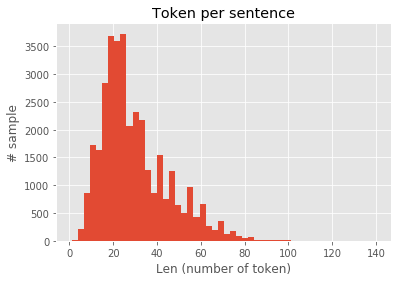

In [14]:
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# sample')
plt.show()

In [15]:
words = list(set(data['word'].values))
words.append('ENDPAD')

In [16]:
n_words = len(words)
n_words

30173

In [17]:
tags = list(set(data['tag'].values))

In [18]:
n_tags = len(tags)
n_tags

17

# Prepare dataset

1. Convert token and tag into integers.
1. Pad the sentences and tags of sentence to max sentence length.
1. Convert tags into categorical value
1. Split data into train and test set.

### 1. Convert words into integers

In [19]:
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in tag2idx.items()}

In [20]:
word2idx['Obama']

26013

In [21]:
idx2word[3885]

'columbite-tantalite'

In [22]:
tag2idx['O']

16

In [23]:
idx2tag[10]

'B-org'

### 2. Padding all the sequences and tags to create fix length sequences (max_len sentence)

In [24]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [25]:
X = [[word2idx[w] for w, t in s] for s in sentences]
X[0]

[14231,
 10794,
 16263,
 6973,
 25163,
 15096,
 8714,
 17404,
 15637,
 22932,
 9812,
 19411,
 9105,
 15599,
 19416,
 22932,
 23279,
 10794,
 27695,
 19642,
 20031,
 9618,
 16905,
 25301,
 14231,
 10794,
 16263,
 6973,
 25163,
 15096,
 8714,
 17404,
 15637,
 22932,
 9812,
 19411,
 9105,
 15599,
 19416,
 22932,
 23279,
 10794,
 27695,
 19642,
 20031,
 9618,
 16905,
 25301]

In [26]:
idx2word[6651]

'Zonen'

In [27]:
len(X[0]), len(X[1])

(48, 60)

In [28]:
X = pad_sequences(maxlen=140, sequences=X, padding="post", value=n_words - 1)

In [29]:
len(X[0]), len(X[1])

(140, 140)

In [30]:
X[0][-1]

30172

In [31]:
idx2word[30172]

'ENDPAD'

In [32]:
y = [[tag2idx[t] for w, t in s] for s in sentences]

In [33]:
len(y[0]), len(y[1])

(48, 60)

In [34]:
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [35]:
y.shape

(35177, 140)

In [36]:
len(y[0]), len(y[1])

(140, 140)

### 3. Convert tags into categorical value

In [37]:
from keras.utils import to_categorical

In [38]:
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

In [39]:
y.shape

(35177, 140, 17)

### 4. Split data into train and test set

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("# train set:", X_train.shape[0])
print("# test set:", X_test.shape[0])

# train set: 28141
# test set: 7036


In [42]:
X_train.shape

(28141, 140)

## Build the Model

In [43]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

### Word Embedding:
- A word embedding is a class of approaches for representing words and documents using a `dense vector` representation.
- words are represented by dense vectors where a vector represents the projection of the word into a `continuous vector space`.
- The `position` of a word within the vector space is learned from text and is based on the words that surround the word when it is used.
- The position of a word in the learned vector space is referred to as its `embedding`.
- `Word2Vec` & `GloVe` are carefully designed and more efficient methods of learning word embeddings from text.
- But word embeddings can be learned as part of a `deep learning model`. This can be a `slower approach`, but `tailors` the model to a specific training dataset.

In [44]:
input = Input(shape=(140,))

#output of Embedding layer is 2D vector with one embedding for each word in the input sequence of words
X = Embedding(input_dim=n_words, output_dim=140, input_length=140)(input)            # [None, 140, 140]
X = Dropout(0.1)(X)                                                                  # [None, 140, 140]
X = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(X)  # [None, 140, 200] 200 becuase it's bidirectinal
out = TimeDistributed(Dense(n_tags, activation='softmax'))(X)                        # [None, 140, 17]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [45]:
model = Model(input, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 140)          4224220   
_________________________________________________________________
dropout_1 (Dropout)          (None, 140, 140)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 200)          192800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 140, 17)           3417      
Total params: 4,420,437
Trainable params: 4,420,437
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 22512 samples, validate on 5629 samples
Epoch 1/2
22512/22512 [==============================] - 409s 18ms/step - loss: 0.1288 - acc: 0.9755 - val_loss: 0.0397 - val_acc: 0.9893
Epoch 2/2
22512/22512 [==============================] - 374s 17ms/step - loss: 0.0289 - acc: 0.9918 - val_loss: 0.0282 - val_acc: 0.9917


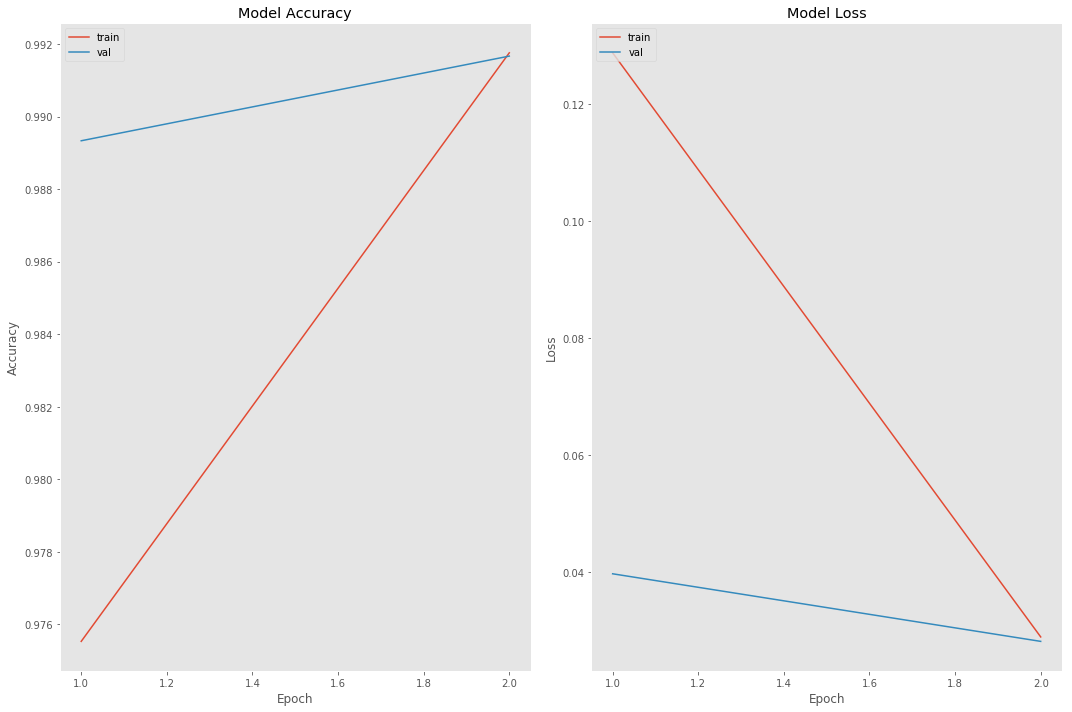

In [48]:
import matplotlib.pyplot as plt

trainAcc = history.history['acc']
trainLoss = history.history['loss']
valAcc = history.history['val_acc']
valLoss = history.history['val_loss']
epoch_it = np.arange(1,2+1)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.plot(epoch_it, trainAcc)
plt.plot(epoch_it, valAcc)
plt.title('Model Accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.subplot(122)
plt.plot(epoch_it, trainLoss)
plt.plot(epoch_it, valLoss)
plt.title('Model Loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

## Evaluate the model on test set

In [49]:
print("Accuray :", model.evaluate(X_test, y_test)[1])

7036/7036 [==============================] - 40s 6ms/step
Accuray : 0.9914348643228641


### Do some predictions

In [50]:
np.array([X_test[0]]).shape

(1, 140)

In [51]:
i = 2
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} {:5}".format("Word", "Predicted Entity"))
print("-------------------------------")
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(idx2word[w],idx2tag[pred]))


Word           Predicted Entity
-------------------------------
Montenegro    : B-geo
is            : O
pursuing      : O
its           : O
own           : O
membership    : O
in            : O
the           : O
World         : O
Trade         : O
Organization  : I-org
and           : O
signed        : O
a             : O
Stabilization : B-org
and           : O
Association   : B-org
agreement     : O
with          : O
the           : O
European      : B-org
Union         : I-org
in            : O
October       : B-tim
2007          : I-tim
.             : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDP